<a href="https://colab.research.google.com/github/Stefano-t/AMD-SMML-project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Kaggle and download the dataset

In [1]:
!pip install --upgrade --force-reinstall --no-deps kaggle

!mkdir ~/.kaggle
!echo '{"username":"stefanotaverni","key":"c22f4c36169267251f92367e36c7d6fc"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d census/2013-american-community-survey
!mkdir /content/data
print("unzip folder...")
!unzip /content/2013-american-community-survey.zip -d /content/data > /dev/null
print("download completed")

     |████████████████████████████████| 61kB 3.1MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=6e0e8892e4aeffa13d3d357d6624b7975324c6c2fff2ba9eb83353c8ad1898d2
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10
 98% 895M/916M [00:04<00:00, 190MB/s]
100% 916M/916M [00:04<00:00, 201MB/s]
unzip folder...
download completed


# Download Spark and setup the environment

In [2]:
!rm spark-3.0.1-bin-hadoop2.7.tgz*
print("update system and install jdk 8")
!apt-get update > /dev/null
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
print("download and extract Spark...")
!wget -q https://downloads.apache.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar xf spark-3.0.1-bin-hadoop2.7.tgz > /dev/null
!pip install -q findspark

print("setup Spark...")
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"
import findspark
findspark.init("spark-3.0.1-bin-hadoop2.7")# SPARK_HOME
from pyspark.sql import SparkSession

spark_driver_memory = "8g"
spark_executor_memory = "1g"

spark = SparkSession.builder \
                    .config("spark.driver.memory", spark_driver_memory) \
                    .config("spark.execuror.memory", spark_executor_memory) \
                    .master("local[*]") \
                    .getOrCreate()
print("Spark session created")
import pyspark
sc = spark.sparkContext
print("Spark context created")

rm: cannot remove 'spark-3.0.1-bin-hadoop2.7.tgz*': No such file or directory
update system and install jdk 8
download and extract Spark...
setup Spark...
Spark session created
Spark context created


# VARIABLES
Definition of the main variables to work with.

In [3]:
import numpy as np

In [4]:
dataset_to_load = "ss13pusa.csv"
dataset_sample_fraction = 0.1
dataset_sample_seed = 1965
"""Determine how to divide the loaded dataset.

The fraction must be a value > 0 and <= 1, and the seed determines the random
seed used to split the starting dataset.
"""

target_label = "PINCP"
forbidden_columns = ["PERNP", "WIGP"]
"""Label to predict and columns to remove."""


split_weights = [0.9, 0.1]
split_seed = 12345
"""Determine how to split the pre-processed Dataframe.

The first weight refers to the training set, and the second to the test set.
They both need to be values between 0 and 1, and sum up to 1.
"""

missing_label_substitution = None
"""string: how to fill the missing values in target label

Setting the variable to "zero" means substitute empty target cell with 0; a
value of None means removing the entire row where datum is missing.
"""

nan_substitution_strategy = 'mean'
"""string: The strategy to use to remove NaN.

The string can assume the following values:
    - "mean"
    - "median"
"""

pca_new_space_dimension = 10
"""int: Number of features to preserve with PCA """

cross_validation_folds = 5
cross_validation_internal_split_seed = 1234
cross_validation_alphas = [*np.logspace(-8, 0, 7), *np.logspace(0.1, 3, 8)]
"""Number of folds and list of alphas to use in cross validation.

Alphas must be a list of values, each of which will be used as ridge regression
hyperparameter.

The seed is used for internal splitting of the folds.
"""

caching = True
"""bool: Decide to cache or not some RDDs. """

outlier_strategy = None
"""string: The strategy used to trim outliers

The admitted string are:
    - "iqr" = use the interquartile range.

If set to None, no trim is performed.
"""

number_of_partitions = sc.defaultParallelism * 2
"""int: Define the level of parallelelism to use

By default, `defaultParallelism` corresponds to the number of cores of the machine.
As a rule of thumbs, a good choice for the number of partitions is two/three times
the amount of cores.
"""

verbose = False
"""bool: Print information about some expensive operation.

This flag is used as a guard for some cpu expensive operation: set it to False
to increase the execution time.
"""

print()

# Load data into DataFrame

In [5]:
# base_path = "/home/stefano/codes/progetto_amd_prova/"
base_path = '/content/data/'
df = spark.read.csv(base_path + dataset_to_load,
                    inferSchema=True,
                    header=True) \
               .sample(withReplacement=False,
                       fraction=dataset_sample_fraction,
                       seed=dataset_sample_seed)

if verbose:
    print('The loaded dataframe has the following shape: {} rows - {} columns'
          .format(df.count(), len(df.columns)))

In [6]:
if verbose: df.describe(target_label).show()

# Preprocessing

## remove unused columns

In [7]:
# remove banned columns
print('The following columns cannot be used in prediction: {}'.format(forbidden_columns))
df = df.drop(*forbidden_columns)
print('The new total number of column is {}'.format(len(df.columns)))

# remove columns of string type
print('Remove columns which have string type')
str_type_cols = [t[0] for t in df.dtypes if t[1] == 'string']
print('The following columns are going to be removed: {}'.format(str_type_cols))
df = df.drop(*str_type_cols)
print('The new total number of column is {}'.format(len(df.columns)))
print()

The following columns cannot be used in prediction: ['PERNP', 'WIGP']
The new total number of column is 282
Remove columns which have string type
The following columns are going to be removed: ['RT', 'NAICSP', 'SOCP']
The new total number of column is 279



In [8]:
import pyspark.sql.functions as F

In [9]:
# cast all values to float
print('Casting all values to float\n')
df = df.select(*(F.col(c).cast("float").alias(c) for c in df.columns))

Casting all values to float



## manage missing values in target label

In [10]:
if missing_label_substitution == "zero":
    df = df.fillna({target_label: 0})
else:
    df = df.filter(df[target_label].isNotNull())
if verbose: 
    print("The new total number of rows is {}".format(df.count()))

# Split dataframe into training and test set

In [11]:
df_train, df_test = df.randomSplit(split_weights,
                                   seed=split_seed)

print("Dimensions: training set = {}, test set = {}"
      .format(df_train.count(),
              df_test.count()))

Dimensions: training set = 119439, test set = 13530


## find out and trim the outliers

In [12]:
def compute_quantiles(dataframe, percentiles, approx):
    return dataframe.approxQuantile(target_label,
                                    percentiles,
                                    approx)

In [13]:
if outlier_strategy == "iqr":
    approx = 0.01

    percentiles = [.25, .75]

    quantiles = compute_quantiles(df_train,
                                  percentiles,
                                  approx)

    min_label = df_train.select(F.min(target_label).alias("MIN")) \
                        .limit(1) \
                        .collect()[0].MIN
    max_label = df_train.select(F.max(target_label).alias("MAX")) \
                        .limit(1) \
                        .collect()[0].MAX

    iqr = quantiles[1] - quantiles[0]
    lower_whisker = quantiles[0] - iqr * 1.5
    upper_whisker = quantiles[1] + iqr * 1.5

    lower_whisker = lower_whisker if lower_whisker > min_label else min_label
    upper_whisker = upper_whisker if upper_whisker < max_label else max_label


    print("quantiles: {}\n whiskers: {},{}"
          .format(quantiles,
                  lower_whisker,
                  upper_whisker))

    df_train = df_train.filter(df_train[target_label] > lower_whisker) \
                       .filter(df_train[target_label] < upper_whisker)

    if verbose:
        df_train.describe(target_label).show()

else:
    print("no outlier trimming performed")

no outlier trimming performed


## substitute NaN values with the mean of corresponding column

In [14]:
from pyspark.ml.feature import Imputer

In [15]:
%%time
# create the imputer
imputer = Imputer(strategy=nan_substitution_strategy,
                  inputCols=df.columns,
                  outputCols=df.columns)

# transoform the entire dataframe according to the model
imputer_model = imputer.fit(df_train)
df_train = imputer_model.transform(df_train)

CPU times: user 101 ms, sys: 20.2 ms, total: 121 ms
Wall time: 1min 22s


# Tranform dataset

First create a new column which is the union of all other columns except the target label.
Then scale all features, removing mean and stddev.
Finally, performe a PCA reduction over the scaled features.

In [16]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA

In [17]:
%%time

fet_vec_output_col = "features"
std_scaler_output_col = "features_scaled"
final_output_col = "pca_features"

features = df_train.columns
features.remove(target_label)

features_vec = VectorAssembler(inputCols=features,
                               outputCol=fet_vec_output_col)

df_train = features_vec.transform(df_train)

standard_scaler = StandardScaler(inputCol=fet_vec_output_col,
                                     outputCol=std_scaler_output_col)

std_scaler_model = standard_scaler.fit(df_train)
df_train = std_scaler_model.transform(df_train)


pca = PCA(k=pca_new_space_dimension,
          inputCol=std_scaler_output_col,
          outputCol=final_output_col)

pca_model = pca.fit(df_train)
df_train = pca_model.transform(df_train)


df_train = df_train.select([target_label, final_output_col])

if verbose:
    print("Dataframe of target/features values has the following shape: {} rows, {} cols"
         .format(df_train.count(), len(df_train.columns)))

df_train.show()

+-------+--------------------+
|  PINCP|        pca_features|
+-------+--------------------+
|40000.0|[-14.076030334049...|
|10300.0|[-8.7765028279461...|
|32100.0|[-19.934438512179...|
| 5800.0|[-17.798616706239...|
|25000.0|[-10.182498559338...|
|20000.0|[-8.5391589492909...|
|65000.0|[-12.846421406873...|
|52000.0|[-11.238998502376...|
|35000.0|[-13.161889730815...|
|73000.0|[-11.057026909934...|
|11000.0|[-9.9040030518388...|
|    0.0|[-20.376572894840...|
|27000.0|[-20.435485716503...|
|14400.0|[-9.7584609821443...|
|12600.0|[-16.431127597415...|
|75000.0|[-18.070166260184...|
|23000.0|[-14.135962118402...|
|53000.0|[-12.031699846173...|
|45400.0|[-16.206632940454...|
|27000.0|[-26.047595904914...|
+-------+--------------------+
only showing top 20 rows

CPU times: user 78.3 ms, sys: 18 ms, total: 96.2 ms
Wall time: 3min 13s


In [18]:
print("PCA retained variance: {}"
     .format(sum(pca_model.explainedVariance)))

PCA retained variance: 0.4256473731635593


# Apply changes to test dataframe


In [19]:
df_test = imputer_model.transform(df_test)

df_test = features_vec.transform(df_test)
df_test = std_scaler_model.transform(df_test)

df_test = pca_model.transform(df_test)

df_test = df_test.select([target_label, final_output_col])

df_test.show()

+-------+--------------------+
|  PINCP|        pca_features|
+-------+--------------------+
|70000.0|[-10.806710139012...|
|21000.0|[-13.847285581678...|
|18980.0|[-8.9840899123966...|
|40000.0|[-16.526499283089...|
|89030.0|[-16.456422608203...|
|79000.0|[-12.961607353187...|
|46200.0|[-14.179455749497...|
| 6000.0|[-22.701528758852...|
|68400.0|[-12.512844375223...|
|60000.0|[-15.945361077706...|
| 1040.0|[-11.894937855953...|
|20000.0|[-18.762704342964...|
| 7300.0|[-15.870320372926...|
|27600.0|[-27.152284354604...|
|    0.0|[-64.740777582202...|
|    0.0|[-13.306288844964...|
|    0.0|[-15.954718178044...|
| 8000.0|[-24.245696278069...|
|80000.0|[-11.424014649605...|
|14400.0|[-14.474977593794...|
+-------+--------------------+
only showing top 20 rows



# Create RDD from DataFrame

In [20]:
training_set = df_train.rdd
test_set = df_test.rdd

print(training_set.take(3))
print(test_set.take(3))

[Row(PINCP=40000.0, pca_features=DenseVector([-14.076, 0.3752, 78.3777, -34.9447, -46.6208, 18.724, -1.4728, -24.4823, -15.6499, 155.0207])), Row(PINCP=10300.0, pca_features=DenseVector([-8.7765, 0.6403, 71.0698, -38.8452, -48.3646, 15.9997, -1.7763, -22.1098, -15.3257, 155.9745])), Row(PINCP=32100.0, pca_features=DenseVector([-19.9344, 1.5305, 73.6912, -35.0338, -46.4913, 18.6118, 1.0388, -25.6311, -12.5217, 155.416]))]
[Row(PINCP=70000.0, pca_features=DenseVector([-10.8067, 1.3712, 78.9317, -34.8086, -46.8521, 17.7422, -0.424, -24.285, -15.7259, 154.4598])), Row(PINCP=21000.0, pca_features=DenseVector([-13.8473, 0.3362, 71.9388, -37.8295, -48.2731, 17.328, 1.1888, -24.9891, -14.0493, 156.2343])), Row(PINCP=18980.0, pca_features=DenseVector([-8.9841, 2.0854, 76.0364, -40.1472, -49.5669, 15.7291, 1.1611, -21.8209, -13.6226, 157.1515]))]


In [21]:
from pyspark.mllib.feature import LabeledPoint

In [22]:
def to_labeledPoint(row, label_col, features_col):
    label = row[label_col]
    # DenseVector can't be used to create a LabeledPoint
    features = row[features_col].values
    return LabeledPoint(label, features)

In [23]:
training_set = training_set.map(lambda row: to_labeledPoint(row,
                                                            target_label,
                                                            final_output_col))

test_set = test_set.map(lambda row: to_labeledPoint(row,
                                                    target_label,
                                                    final_output_col))
if caching: test_set.cache()

training_set = training_set.repartition(12)
test_set = test_set.repartition(12)

print(training_set.take(3))
print(test_set.take(3))

[LabeledPoint(18030.0, [-16.75527995183764,0.4311057124227683,72.31312070990249,-37.33779747670341,-48.174911840880846,17.766638223325618,0.2016596724996449,-24.300921539363056,-14.771846581117833,155.34603236624702]), LabeledPoint(33000.0, [-8.922626786583571,4.555364694792091,78.48307146417535,-35.585004642814646,-47.72553158125825,16.264040325489844,-2.480689709254465,-24.289823162632395,-15.32981045297642,152.2183031267988]), LabeledPoint(910.0, [-16.424472744033466,9.839017920594179,75.8924201825518,-38.19904578728358,-51.93611797490557,14.138111350092194,-0.7228908097206918,-27.0019964901969,-12.528309832441222,157.55439696303145])]
[LabeledPoint(60000.0, [-12.495980279903184,0.28220049222683335,77.92860723870038,-34.838314645219754,-47.52224910619122,19.117637612909515,-1.1626543503828828,-24.477615581774817,-16.374679895573404,154.27109565031043]), LabeledPoint(0.0, [-16.71535599534817,0.3019438526338772,74.63645585052456,-37.57264182690288,-50.20214379494807,17.971819461407414

# Function estimator

In [24]:
def squared_err(expected, prediction):
    '''Compute the squared error, i.e. the squared difference between the inputs'''    
    return (expected - prediction) ** 2

In [25]:
def mean_squared_error(rdd):
    '''Compute the mean squared error of the given RDD.
    
    The RDD must be of the form RDD[(float, float)]
    '''
    return rdd.map(lambda p: squared_err(*p)).mean()

In [26]:
def root_mean_squared_error(rdd):
    '''Computes the root mean squared error of the given RDD.
    
    The RDD in input must be of the form RDD[(float, float)]'''
    return np.sqrt(mean_squared_error(rdd))

In [27]:
def r2(rdd):
    '''Computes the R2 coefficient of determination
    
    The RDD in input must be of the form RDD[(float, float)], where the first float
    is the actual value, and the second float is the predicted value.
    '''
    mean_ = rdd.map(lambda t: t[0]).mean()
    sum_squares = rdd.map(lambda t: (t[0] - mean_)**2).sum()
    residual_sum_squares = rdd.map(lambda t: squared_err(*t)).sum()
    return 1 - (residual_sum_squares / sum_squares)

# Baseline algorithm


In [28]:
# get label main
label_mean = training_set.map(lambda lp: lp.label).mean()

# create and RDD of (label, prediction)
baseline_train_prediction_rdd = training_set.map(lambda lp: (lp.label, label_mean))

# predict test set
baseline_test_prediction_rdd = test_set.map(lambda lp: (lp.label, label_mean))

## compute stats
# mse
baseline_train_mse = mean_squared_error(baseline_train_prediction_rdd)
baseline_test_mse = mean_squared_error(baseline_test_prediction_rdd)

# rmse
baseline_train_rmse = root_mean_squared_error(baseline_train_prediction_rdd)
baseline_test_rmse = root_mean_squared_error(baseline_test_prediction_rdd)

print('BASELINE VALUES\n'
      '\tMSE:\n\ttrain: {:.5e}\n\ttest: {:.5e}'.format(baseline_train_mse, baseline_test_mse))
print('\tRMSE:\n\ttrain: {:.5e}\n\ttest: {:.5e}'.format(baseline_train_rmse, baseline_test_rmse))

BASELINE VALUES
	MSE:
	train: 2.99490e+09
	test: 3.32687e+09
	RMSE:
	train: 5.47257e+04
	test: 5.76791e+04


# Ridge regression

In [29]:
def outer_product(lp):
    '''Computes the outer product of the features of the LabeledPoint with themselves.
    
    This method is meant to be used inside a map function of an RDD[LabeledPoint]
    
    The outer product of the input is defined as:
        lp.features x lp.features'
    returning an m x m matrix, with m dimension of the vector lp.features
    '''
    return np.array([np.dot(i,lp.features) for i in lp.features])

In [30]:
def outer_sum(m1, m2):
    '''Sums two matrixes'''
    return m1+m2

In [31]:
def stripes_product(rdd):
    '''Multiplies the design matrix with the feature vector of corresponding label
    
    The input must be and RDD[LabeledPoint]
    
    Computes a matrix-vector product, multipling each feature vector with the corresponding scalar label.
    It is not necessary to transponse the matrix.
    '''
    return rdd.map(lambda lp: lp.label*lp.features).reduce(lambda v1, v2: v1+v2)

In [32]:
def ridge_regression(rdd, alpha=1):
    '''Creates the ERM weights according to Ridge Regression model
    
    The RDD in input must be of the form RDD[LabeledPoint]
    '''
    A = rdd.map(outer_product).reduce(outer_sum)
    np.fill_diagonal(A, A.diagonal()+alpha)
    V = stripes_product(rdd)
    return np.linalg.inv(A).dot(V)

In [33]:
def predict(weights, features):
    '''Predicts the output according to the given weights and features'''
    return np.dot(weights, features)

In [34]:
def cross_validation(rdd, k, alpha_set, m=None, seed=None, verbose=False):
    '''Computes the cross validation over the given RDD
    
    The RDD in input must be of the form RDD[LabeledPoint]
    
    The returned value is a dictonary, where the keys are the given alpha inside
    alpha_set, and the values are a list of tuple, where each tuple is of the form:
            (fold error, fold r2 score)
    '''
    # split the rdd into k folds
    split_weights = np.repeat(1/k, k)
    folds = rdd.randomSplit(split_weights, seed=seed)
    
    if m is None:
        m = rdd.count()
        if verbose: print("count computed")

    scaling_factor = k / m
    risks = {a: [] 
             for a 
             in alpha_set}
    
    for i in range(k):
        Di = folds[i] # validation fold
        if caching: Di.cache()
        Si = folds[:i] + folds[i+1:] # all folds except Di
        training_part = sc.union(Si) # creates testing RDD
        training_part = training_part.repartition(12)
        
        for alpha in alpha_set:
            _w = ridge_regression(training_part, alpha)
            predicted_rdd_ = Di.map(lambda lp: (lp.label, predict(_w, lp.features)))
            fold_r2 = r2(predicted_rdd_)
            fold_error = scaling_factor * predicted_rdd_.map(lambda t: squared_err(*t)) \
                                                        .sum()
            risks[alpha].append((fold_error, fold_r2))
            if verbose: print('.', end='')
        if caching: Di.unpersist()
        print(" fold {} computed".format(i+1))

    return risks


In [35]:
%%time

# call once for all CV
m = training_set.count()

risks = cross_validation(training_set,
                         cross_validation_folds, 
                         cross_validation_alphas, 
                         m=m, 
                         seed=cross_validation_internal_split_seed, 
                         verbose=True)

............... fold 1 computed
............... fold 2 computed
............... fold 3 computed
............... fold 4 computed
............... fold 5 computed
CPU times: user 4.82 s, sys: 4.68 s, total: 9.51 s
Wall time: 15min 9s


In [36]:
cv_risks = {
    alpha: [t[0] for t in risk]
    for alpha, risk 
    in risks.items()
}

scores = {
    alpha: [t[1] for t in risk]
    for alpha, risk 
    in risks.items()
}

# computes CV risks
for k, v in cv_risks.items():
    cv_risks[k] = sum(v) / len(v)

min_alpha, min_risk = min(cv_risks.items(), key=lambda t: t[1])

print("The minimum risk is {:.5E}, given by alpha={:.6}"
      .format(min_risk, min_alpha))

The minimum risk is 2.13850E+09, given by alpha=148.398


In [37]:
import seaborn as sbn
import matplotlib.pyplot as plt

Plot the expected risk against alpha value

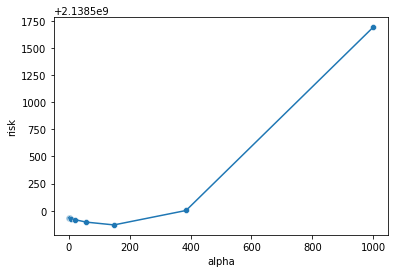

In [38]:
alpha_values = list(cv_risks.keys())
expected_risks = list(cv_risks.values())

_ = sbn.lineplot(x=alpha_values,
                 y=expected_risks)
ax = sbn.scatterplot(x=alpha_values,
                     y=expected_risks)
ax.set_xlabel("alpha")
_ = ax.set_ylabel("risk")

Plot the R2 score against the alpha value

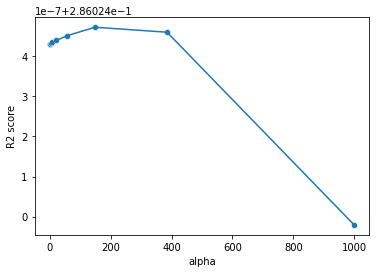

In [39]:
mean_scores = [np.mean(i)
               for i
               in scores.values()]

_ = sbn.lineplot(x=list(scores.keys()),
             y=mean_scores)
ax = sbn.scatterplot(x=list(scores.keys()),
             y=mean_scores)
ax.set_xlabel("alpha")
_ = ax.set_ylabel("R2 score")

In [40]:
weights = ridge_regression(training_set, alpha=min_alpha)
#print(weights)
#print("weights computed")

# prediction the same training set
ridge_train_prediction_rdd = training_set.map(lambda lp:
                                              (lp.label, predict(weights,
                                                                 lp.features)))

# prediction onto test set
ridge_test_prediction_rdd = test_set.map(lambda lp:
                                         (lp.label, predict(weights,
                                                            lp.features)))

# compute stats
# mse
ridge_train_mse = mean_squared_error(ridge_train_prediction_rdd)
ridge_test_mse = mean_squared_error(ridge_test_prediction_rdd)

# rmse
ridge_train_rmse = root_mean_squared_error(ridge_train_prediction_rdd)
ridge_test_rmse = root_mean_squared_error(ridge_test_prediction_rdd)

# r2
ridge_train_r2 = r2(ridge_train_prediction_rdd)
ridge_test_r2 = r2(ridge_test_prediction_rdd)

print('RIDGE REGRESSION\n'
      'Train\n'
      '\tMSE: {:.5e}\n'
      '\tRMSE: {:.5e}\n'
      '\tR2: {:.3}'
      .format(ridge_train_mse,
              ridge_train_rmse,
              ridge_train_r2))

print('Test\n'
      '\tMSE: {:.5e}\n'
      '\tRMSE: {:.5e}\n'
      '\tR2: {:.3}'
      .format(ridge_test_mse,
              ridge_test_rmse,
              ridge_test_r2))

RIDGE REGRESSION
Train
	MSE: 2.13819e+09
	RMSE: 4.62406e+04
	R2: 0.286
Test
	MSE: 2.38882e+09
	RMSE: 4.88756e+04
	R2: 0.282


Plot the prediction of ridge regression model against the true value of the label.

The smaller and the lighter the point, the better the prediction is.

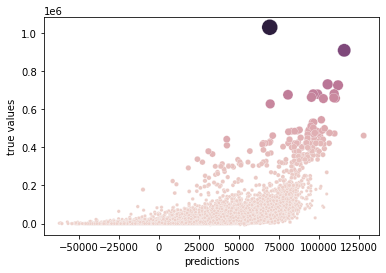

In [41]:
%matplotlib inline

predictions = np.asarray(
    ridge_test_prediction_rdd \
        .map(lambda t: t[1]) \
        .collect())

actual = np.asarray(
    ridge_test_prediction_rdd \
        .map(lambda t: t[0]) \
        .collect())

error = np.asarray(
    ridge_test_prediction_rdd \
        .map(lambda t: squared_err(*t)) \
        .collect())

    
ax = sbn.scatterplot(x=predictions,
                     y=actual,
                     hue=error,
                     size=error,
                     sizes=(10, 250))

ax.set_ylabel("true values")
_ = ax.set_xlabel("predictions")
ax.legend().remove()